## Park_HeeJI_HW04.ipynb
- Student Name: Hee Ji Park
- Github username : heejipark 
- USC ID: 4090715830
- Contact Email: heejipar@usc.edu

I would like to submit the code for Homework 3 with Homework 4 again, since it need the feature creation code.
So, If you want to check only Homework 4 code, please click the button -> <a href="#HW4">Move to HW4</a>

- <a href="#HW3">Move to HW3</a>
- <a href="#HW4">Move to HW4</a>

<a name='HW3'>Homework3 </a>
## Time Series Classification

In this problem, I will classify the activities of humans based on time series obtained by a Wireless Sensor Network.

The dataset contains 7 folders that represent seven types of activities. In each folder, there are multiple files each of which represents an instant of a human performing an activity. Each file containis 6 time series collected from activities of the same person, which are called avgrss12, varrss12, avgrss13, varrss13, vgrss23, and arrss23. There are 88 instances in the dataset, each of which contains 6 time series and each time series has 480 consecutive values.

### Required libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import bootstrap
import numpy as np
import os
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_selection import RFECV, chi2
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, auc
from sklearn.metrics import f1_score, accuracy_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from itertools import cycle
from scipy import interp
from sklearn.preprocessing import label_binarize

### (c) Feature Extraction
Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.

#### iv. Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).

Mean, Median, Standard Deviation

- Mean: It is the average of all values in a set. Therefore, it helps to measure the central tendency of data.
- Median: This is the middle number in a set of numbers sorted by size. This will be a good measure to figure out the central tendency of data. (If it the variables is skewed or the data have many outliers, Median is better representation.)
- Standard Deviation: It describes how dispersed a set of data is. It compares each data point to the mean of all data points, and standard deviation returns a calculated value that describes whether the data points are in close proximity or whether they are spread out. (A low standard deviation means that most of the numbers are close to the mean (average) value. A high standard deviation means that the values are spread out over a wider range. Therefore, it will help us to know the overal range of the data.)

<hr>

<a name='HW4'>Homework 4----------------------------------------</a>

## 2.Time Series Classification Part 2: Binary and Multiclass Classification

## (a) Binary Classification Using Logistic Regression
Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. 


### i. 
- Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook)

In [2]:
def break_time_series_dataset(N, binding):
    dirFile = './../data/AReM/'
    dirList = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
    colName = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    timeCol = ['min', 'max', 'mean', 'median', 'std', '25%', '75%']
    timeColDic = {'min':0, 'max':0, 'mean':0, 'median':0, 'std':0, '25%':0, '75%':0}
    newCol = ['0_label']
    for time in timeCol:
        for col in colName:
            newCol.append(time+'_'+col)
    train = pd.DataFrame()
    test = pd.DataFrame()

    for dname in dirList:
        file = dirFile + dname 
        fileList = os.listdir(file+'/')
        for csv in fileList:
            temp_df = pd.read_csv(file+'/'+csv, skiprows=4)
            i = int(csv[7])
            if csv[8] != '.': 
                i = int(csv[7:9])

            # for bending2-data4
            if temp_df.isnull().values.any():
                #print("Different format in excel file : ", dname,'/',csv)
                for i in range(len(temp_df)):
                    val = temp_df.loc[i, '# Columns: time'].split()
                    temp_df.loc[i, '# Columns: time'] = val[0]
                    for icol, col in enumerate(colName):
                        temp_df.loc[i, col] = float(val[icol+1])
                #print("Format Change Completed: ", dname,'/',csv)

            # data frame split
            temp_df = np.array_split(temp_df, N)
            row = {}
            for idx in range(0, N):
                row['0_label'] = dname
                des = temp_df[idx].drop(columns=['# Columns: time']).describe()
                for time in timeCol:
                    for col in colName:    
                        if '25%' == time:
                            nc = '1st_quart' + '_' + col + '_' + str(idx)
                        elif '75%' == time:
                            nc = '3rd_quart' + '_' + col + '_' + str(idx)
                        else:
                            nc = time + '_' + col + '_' + str(idx)
                        if time == 'median': 
                            row[nc] = des[col]['50%']
                        else:
                            row[nc] = des[col][time]

            if 'bending' in dname:
                if i > 2: # train
                    train = pd.concat([train, pd.DataFrame.from_records([row])],ignore_index=True)
                if i <= 2: # test
                    test = pd.concat([test, pd.DataFrame.from_records([row])],ignore_index=True)
            else:
                if i > 3: # train
                    train = pd.concat([train, pd.DataFrame.from_records([row])],ignore_index=True)
                if i <= 3:  # test
                    test = pd.concat([test, pd.DataFrame.from_records([row])],ignore_index=True)

    train = train.reset_index(drop=True).reindex(sorted(train.columns), axis=1)
    test = test.reset_index(drop=True).reindex(sorted(train.columns), axis=1)

    # change the column name
    newCol = ['0_label']
    timeCol = sorted(['min', 'max', 'mean', 'median', 'std', '1st_quart', '3rd_quart'])
    for col in timeCol:
        for i in range(N*6):
            newCol.append(col + str(i+1))
    train.columns = newCol
    test.columns = newCol

    
    if binding == True:
        # Bending vs other
        trainDF = train.copy()
        testDF = test.copy()
        for l in dirList:
            if 'bending' in l:
                trainDF = trainDF.replace(l,'bending')
                testDF = testDF.replace(l,'bending')
            else:
                trainDF = trainDF.replace(l,'other')
                testDF = testDF.replace(l,'other')
        return trainDF, testDF
    
    else:
        return train, test

In [3]:
trainDF, testDF = break_time_series_dataset(1, True)

In [4]:
trainDF

,0_label,1st_quart1,1st_quart2,1st_quart3,1st_quart4,1st_quart5,1st_quart6,3rd_quart1,3rd_quart2,3rd_quart3,...,min3,min4,min5,min6,std1,std2,std3,std4,std5,std6
0,bending,43.31,14.25,20.5000,0.43,0.0000,0.0000,44.67,18.0000,23.75,...,11.33,0.0,0.0,0.00,1.618364,3.742420,3.318301,0.263111,0.788985,0.487826
1,bending,42.50,13.00,22.2500,0.00,0.4300,0.4300,45.00,18.2700,24.00,...,8.00,0.0,0.0,0.00,1.386098,3.847638,2.488862,0.315566,0.995761,0.622534
2,bending,39.15,20.50,30.4575,0.00,0.4300,0.0000,45.00,24.3725,36.33,...,20.00,0.0,0.0,0.00,3.670666,3.810469,3.849448,0.630860,0.953730,0.524317
3,bending,41.33,16.50,28.4575,0.43,0.4300,0.0000,42.75,22.0625,31.25,...,23.67,0.0,0.0,0.00,2.243490,4.087107,2.411026,0.405469,0.928801,0.389164
4,bending,43.00,19.75,35.3625,0.00,0.0000,0.0000,45.00,24.0000,36.50,...,29.00,0.0,0.0,0.00,1.558835,3.030943,1.999604,0.338690,0.550657,0.513506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,other,31.00,13.50,13.5000,2.49,2.1700,2.1575,38.00,17.0000,17.75,...,6.25,0.0,0.0,0.00,4.752477,2.711022,3.119856,2.599284,1.500046,1.732727
65,other,31.25,13.67,13.7300,2.49,2.0500,2.1200,38.00,17.3300,17.75,...,4.67,0.0,0.0,0.43,4.796705,2.802066,3.156320,2.388746,1.602504,1.699114
66,other,31.75,13.50,13.7500,2.50,2.0575,2.1700,38.25,17.2500,18.00,...,5.50,0.0,0.0,0.00,4.531720,2.813077,3.131076,2.435437,1.519348,1.690960
67,other,31.50,13.00,14.0000,2.55,2.0375,2.1200,38.00,17.3725,18.25,...,6.50,0.0,0.0,0.00,4.731790,3.036746,2.905688,2.538521,1.591346,1.680170


In [5]:
testDF

,0_label,1st_quart1,1st_quart2,1st_quart3,1st_quart4,1st_quart5,1st_quart6,3rd_quart1,3rd_quart2,3rd_quart3,...,min3,min4,min5,min6,std1,std2,std3,std4,std5,std6
0,bending,39.2500,16.0000,33.0000,0.0000,0.0000,0.0000,42.0000,23.25,36.0000,...,27.25,0.0,0.0,0.0,1.476967,4.462952,2.188449,0.322605,0.965659,0.582915
1,bending,42.0000,19.0000,32.0000,0.0000,0.0000,0.0000,43.6700,22.25,34.5000,...,27.67,0.0,0.0,0.0,1.435550,3.893737,1.995255,0.289158,1.047259,0.601010
2,bending,23.1875,18.0000,20.5000,0.0000,0.0000,0.4300,26.5000,22.00,27.0000,...,10.67,0.0,0.0,0.0,3.737514,4.299612,3.693786,0.837408,0.927048,0.693720
3,bending,25.5000,18.0000,15.0000,0.0000,0.0000,0.4700,30.0000,22.50,20.7500,...,0.00,0.0,0.0,0.0,3.583582,3.826268,5.053642,0.767197,0.904436,1.012342
4,other,34.5000,14.2500,17.9500,1.3000,1.6400,1.5000,40.2500,19.00,21.7500,...,7.00,0.0,0.0,0.0,3.581301,3.430906,2.890347,1.601799,1.600137,1.852600
5,other,35.2500,14.0000,18.0000,1.1200,1.7900,1.4100,40.2500,19.50,21.5000,...,10.50,0.0,0.0,0.0,3.226507,3.691401,2.727377,1.639258,1.625415,1.769203
6,other,34.5000,13.7500,16.0000,1.2500,1.7900,1.5000,40.0625,19.00,21.0000,...,7.50,0.0,0.0,0.0,3.710180,3.537950,3.537144,1.996887,1.612059,1.815730
7,other,27.0000,3.5000,5.5000,0.0000,0.4300,0.4300,29.0000,8.33,10.7500,...,0.00,0.0,0.0,0.0,1.442253,3.468994,4.074511,0.394817,0.777400,0.613688
8,other,48.0000,5.6700,2.0000,0.0000,0.0000,0.3225,48.0000,7.50,5.5425,...,0.00,0.0,0.0,0.0,7.495615,1.936492,3.274539,0.346756,0.749945,0.675781
9,other,48.0000,3.0000,4.6700,0.0000,0.0000,0.4600,48.0000,6.25,10.0000,...,0.00,0.0,0.0,0.0,0.032038,2.566429,3.268502,0.055106,0.447127,0.388372


In [6]:
selected = ['0_label']
for val in ['mean', 'median', 'std']:
    for i in range(0,6):
        selected.append(val + str(i+1))
trainSDF = trainDF[selected]
testSDF = testDF[selected]
trainSDF # extract selected specific column

,0_label,mean1,mean2,mean3,mean4,mean5,mean6,median1,median2,median3,median4,median5,median6,std1,std2,std3,std4,std5,std6
0,bending,43.969125,15.868021,22.103750,0.413125,0.666354,0.555313,44.500,16.250,21.67,0.470,0.470,0.490,1.618364,3.742420,3.318301,0.263111,0.788985,0.487826
1,bending,43.454958,15.793333,23.034792,0.378083,0.849354,0.679646,43.250,15.000,23.50,0.470,0.500,0.500,1.386098,3.847638,2.488862,0.315566,0.995761,0.622534
2,bending,42.179813,22.183625,33.493917,0.696042,0.989917,0.613521,43.500,23.000,35.00,0.500,0.830,0.500,3.670666,3.810469,3.849448,0.630860,0.953730,0.524317
3,bending,41.678063,19.006562,29.857083,0.535979,0.841875,0.383292,41.750,19.125,30.00,0.500,0.500,0.430,2.243490,4.087107,2.411026,0.405469,0.928801,0.389164
4,bending,43.954500,22.122354,35.588458,0.426250,0.497313,0.493292,44.330,23.000,36.00,0.470,0.430,0.430,1.558835,3.030943,1.999604,0.338690,0.550657,0.513506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,other,34.322750,15.209771,15.550458,4.456333,3.277229,3.432562,35.250,15.250,15.75,3.900,3.110,3.200,4.752477,2.711022,3.119856,2.599284,1.500046,1.732727
65,other,34.473188,15.424708,15.704167,4.359312,3.188271,3.340458,35.000,15.500,16.00,3.960,3.030,3.090,4.796705,2.802066,3.156320,2.388746,1.602504,1.699114
66,other,34.873229,15.471188,15.873896,4.380583,3.205688,3.424646,35.250,15.500,16.00,3.925,3.030,3.270,4.531720,2.813077,3.131076,2.435437,1.519348,1.690960
67,other,34.599875,15.173667,16.055563,4.398833,3.145500,3.289542,35.125,15.000,16.00,4.025,3.015,3.015,4.731790,3.036746,2.905688,2.538521,1.591346,1.680170


In [7]:
def selection(colList):
    selected = ['0_label']
    for col in list(trainSDF.columns)[1:]:
        for num in colList:
            if str(num) in col:
                selected.append(col)
    return selected

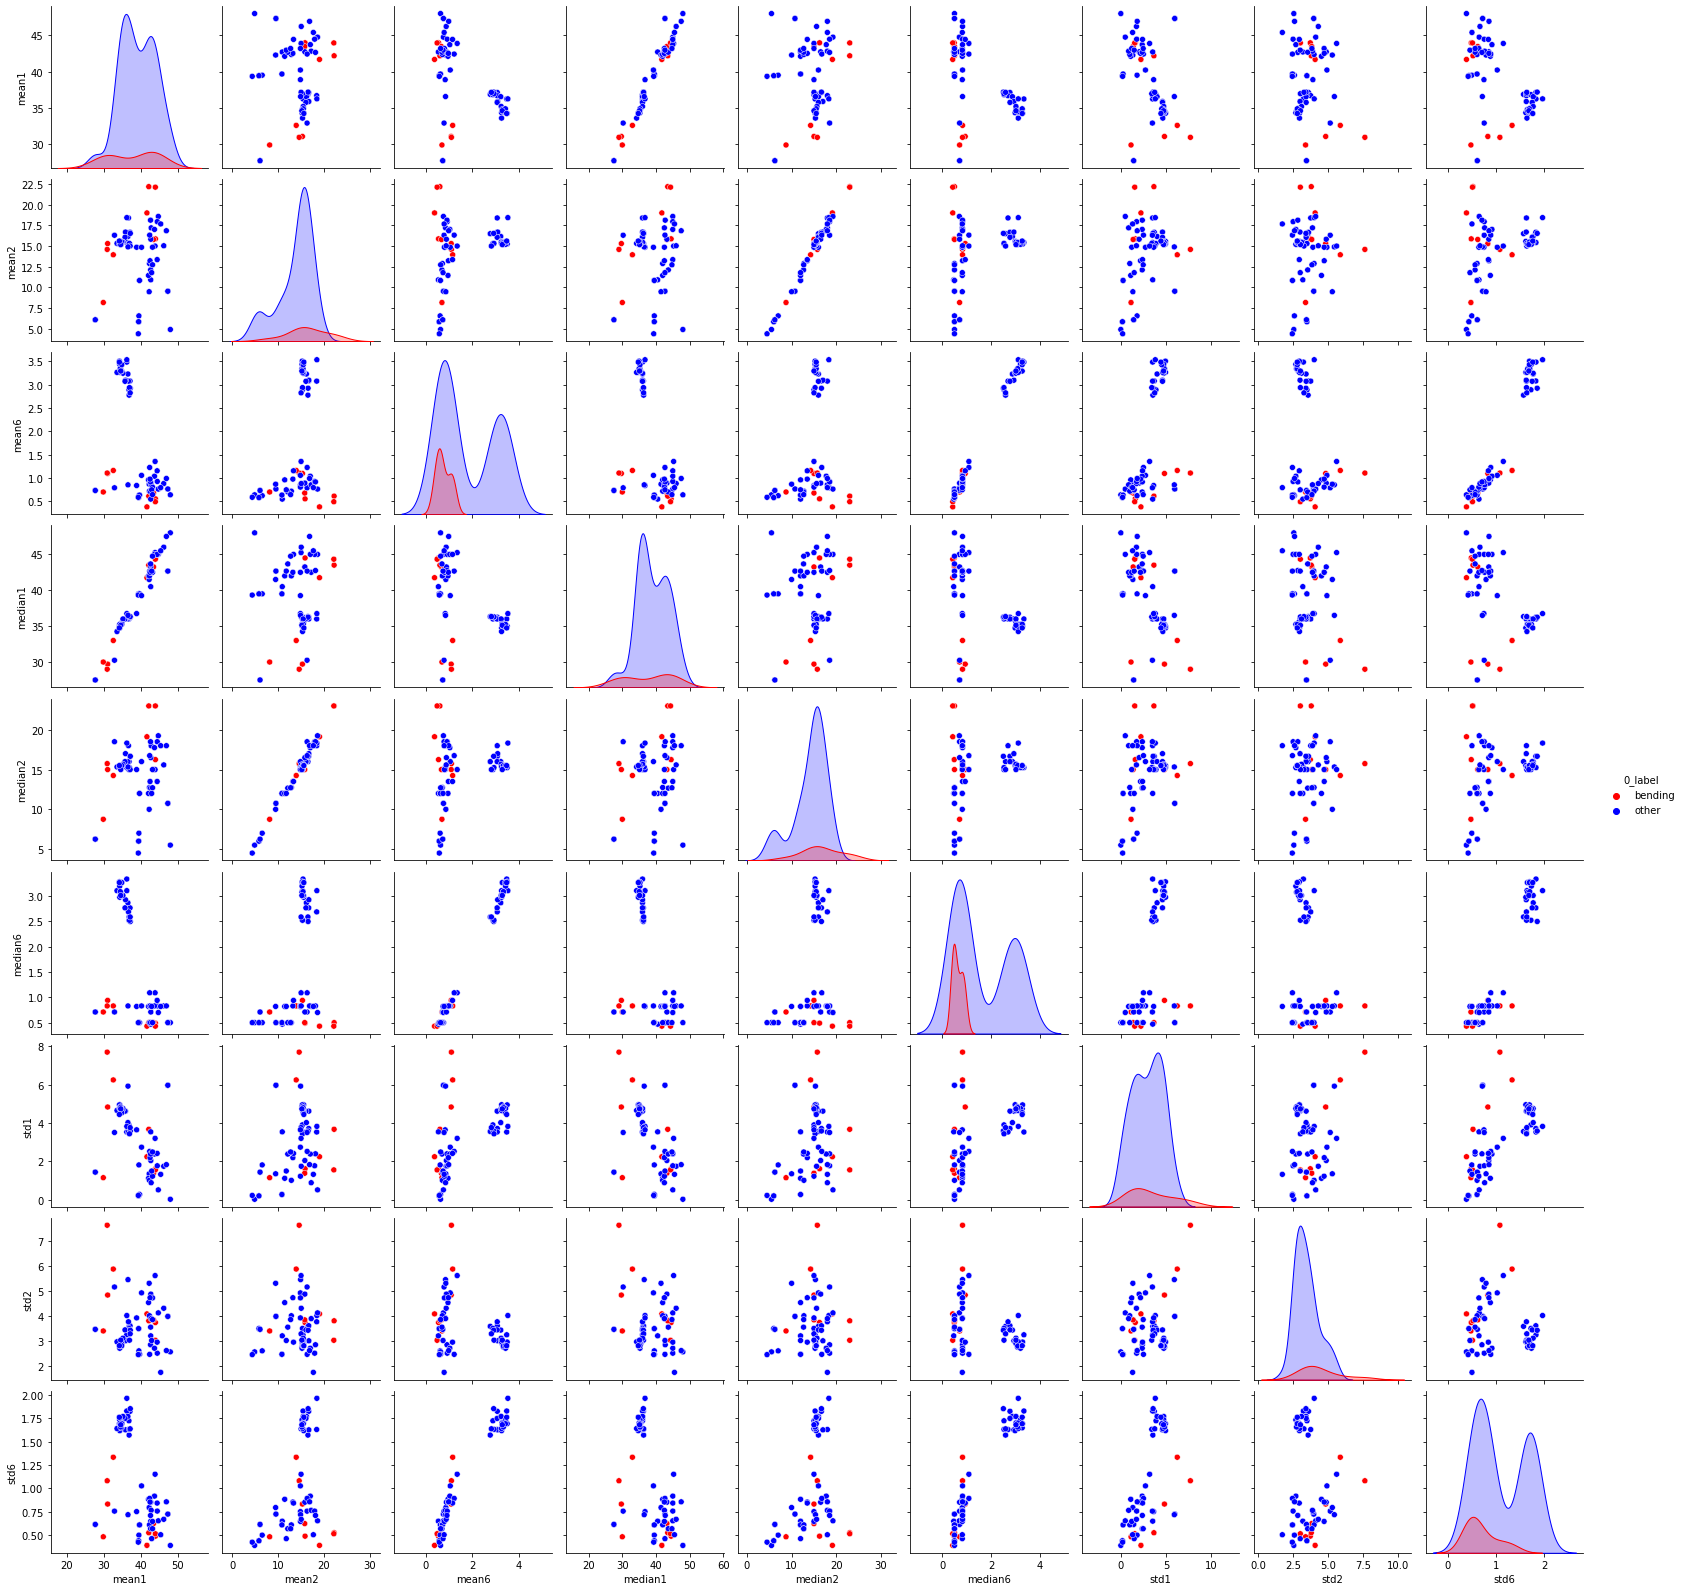

In [8]:
sns.pairplot(data=trainSDF[selection([1,2,6])], hue='0_label', palette={'bending':'red','other':'blue'})

### ii. 
- Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 2(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 2(a)i?

In [9]:
trainDF, testDF = break_time_series_dataset(2, True) # Seperate df into two

In [10]:
trainDF

,0_label,1st_quart1,1st_quart2,1st_quart3,1st_quart4,1st_quart5,1st_quart6,1st_quart7,1st_quart8,1st_quart9,...,std3,std4,std5,std6,std7,std8,std9,std10,std11,std12
0,bending,42.3300,44.2500,14.6275,13.7500,19.25,21.0000,0.0000,0.4300,0.00,...,3.469237,3.933434,4.271610,1.929494,0.284434,0.235493,0.832544,0.744611,0.486847,0.487918
1,bending,43.5000,42.5000,15.1875,12.0000,21.75,22.5000,0.0000,0.4300,0.47,...,4.010149,2.438428,2.967487,1.881721,0.314099,0.260761,1.141589,0.730490,0.718016,0.473445
2,bending,42.0000,37.7500,21.5000,18.6275,36.00,28.7500,0.0000,0.0000,0.43,...,3.123258,4.183731,1.650105,3.760118,0.634285,0.627915,0.769306,1.079233,0.554542,0.491873
3,bending,39.6525,41.5000,15.2500,17.2500,28.50,28.3100,0.4300,0.4300,0.43,...,5.102939,2.725349,2.701406,2.062647,0.489595,0.273050,1.170828,0.456292,0.411200,0.363144
4,bending,43.2500,43.0000,21.7500,18.4575,36.00,33.0000,0.0000,0.4300,0.00,...,2.410625,3.270099,1.315724,2.298693,0.329540,0.342346,0.498420,0.599386,0.526656,0.478528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,other,30.7500,31.1875,13.4575,13.5000,13.33,13.5000,2.8600,2.4375,2.28,...,2.755151,2.671523,3.083111,3.162332,2.762730,2.387460,1.514543,1.479333,1.703098,1.758379
65,other,31.7500,30.7300,13.3100,14.0000,13.73,13.7300,2.4900,2.4900,2.05,...,2.881151,2.723765,3.068400,3.247042,2.396878,2.381634,1.639799,1.565480,1.737420,1.657578
66,other,32.2500,31.5000,13.5000,13.5000,13.50,14.0000,2.4900,2.5500,1.92,...,2.844735,2.786287,3.103469,3.163566,2.341763,2.514203,1.557201,1.483199,1.781928,1.598536
67,other,32.0000,31.4575,13.2500,13.0000,14.25,13.9375,2.4500,2.6900,1.92,...,2.981010,3.097689,2.933582,2.882455,2.512633,2.561608,1.530739,1.652816,1.647640,1.707089


In [11]:
testDF

,0_label,1st_quart1,1st_quart2,1st_quart3,1st_quart4,1st_quart5,1st_quart6,1st_quart7,1st_quart8,1st_quart9,...,std3,std4,std5,std6,std7,std8,std9,std10,std11,std12
0,bending,40.3100,39.0000,15.9375,17.7500,33.0000,31.3100,0.000,0.0000,0.0000,...,4.063161,4.432775,1.212039,2.838110,0.328089,0.316790,0.817856,1.039480,0.647856,0.510494
1,bending,42.0000,42.0000,19.7500,18.1875,33.0000,30.0000,0.000,0.0000,0.0000,...,2.693040,4.794164,1.308788,2.283931,0.258298,0.316617,0.904336,1.127568,0.624834,0.575061
2,bending,22.2500,23.5000,17.2500,18.7500,25.7500,19.4575,0.000,0.0000,0.0000,...,3.636118,4.835328,1.992035,2.392270,1.085015,0.400541,0.780667,1.040881,0.425993,0.818833
3,bending,28.2500,23.5000,18.0000,19.0000,16.7500,12.3300,0.000,0.0000,0.0000,...,2.488367,4.373696,2.448041,6.601229,0.265205,1.006691,0.730268,1.011267,0.521569,1.238675
4,other,34.2500,35.0000,15.0000,13.7500,17.7500,18.0000,1.300,1.3000,1.7225,...,3.603285,3.147638,3.064788,2.710635,1.523329,1.679596,1.622255,1.576561,1.813728,1.890755
5,other,35.2500,35.2500,14.2500,13.7500,17.7500,18.2500,1.250,0.8700,1.9800,...,3.099330,4.175468,2.791432,2.642945,1.574180,1.704584,1.617609,1.624815,1.714630,1.825523
6,other,35.2500,34.0000,13.5000,14.0000,18.5000,14.1875,0.870,1.4100,1.7000,...,3.963206,3.060304,2.773137,3.583310,1.993348,1.961714,1.595135,1.625823,1.684706,1.871377
7,other,27.0000,27.0000,5.5000,2.4575,8.7300,3.3300,0.000,0.0000,0.4700,...,3.054192,3.514457,2.905812,4.223762,0.421739,0.358233,0.692373,0.855122,0.617839,0.603417
8,other,29.5000,48.0000,5.9375,5.5000,4.2500,1.5000,0.000,0.0000,0.0000,...,2.265042,1.510117,3.182239,1.255456,0.467226,0.073622,0.911510,0.513185,0.713668,0.590831
9,other,48.0000,48.0000,5.2500,1.5000,2.7300,9.5000,0.000,0.0000,0.0000,...,2.115595,2.474307,2.840134,0.890673,0.027756,0.072509,0.477418,0.409577,0.437388,0.330623


['0_label', 'mean1', 'mean2', 'mean6', 'mean7', 'mean8', 'mean12', 'median1', 'median2', 'median6', 'median7', 'median8', 'median12', 'std1', 'std2', 'std6', 'std7', 'std8', 'std12']


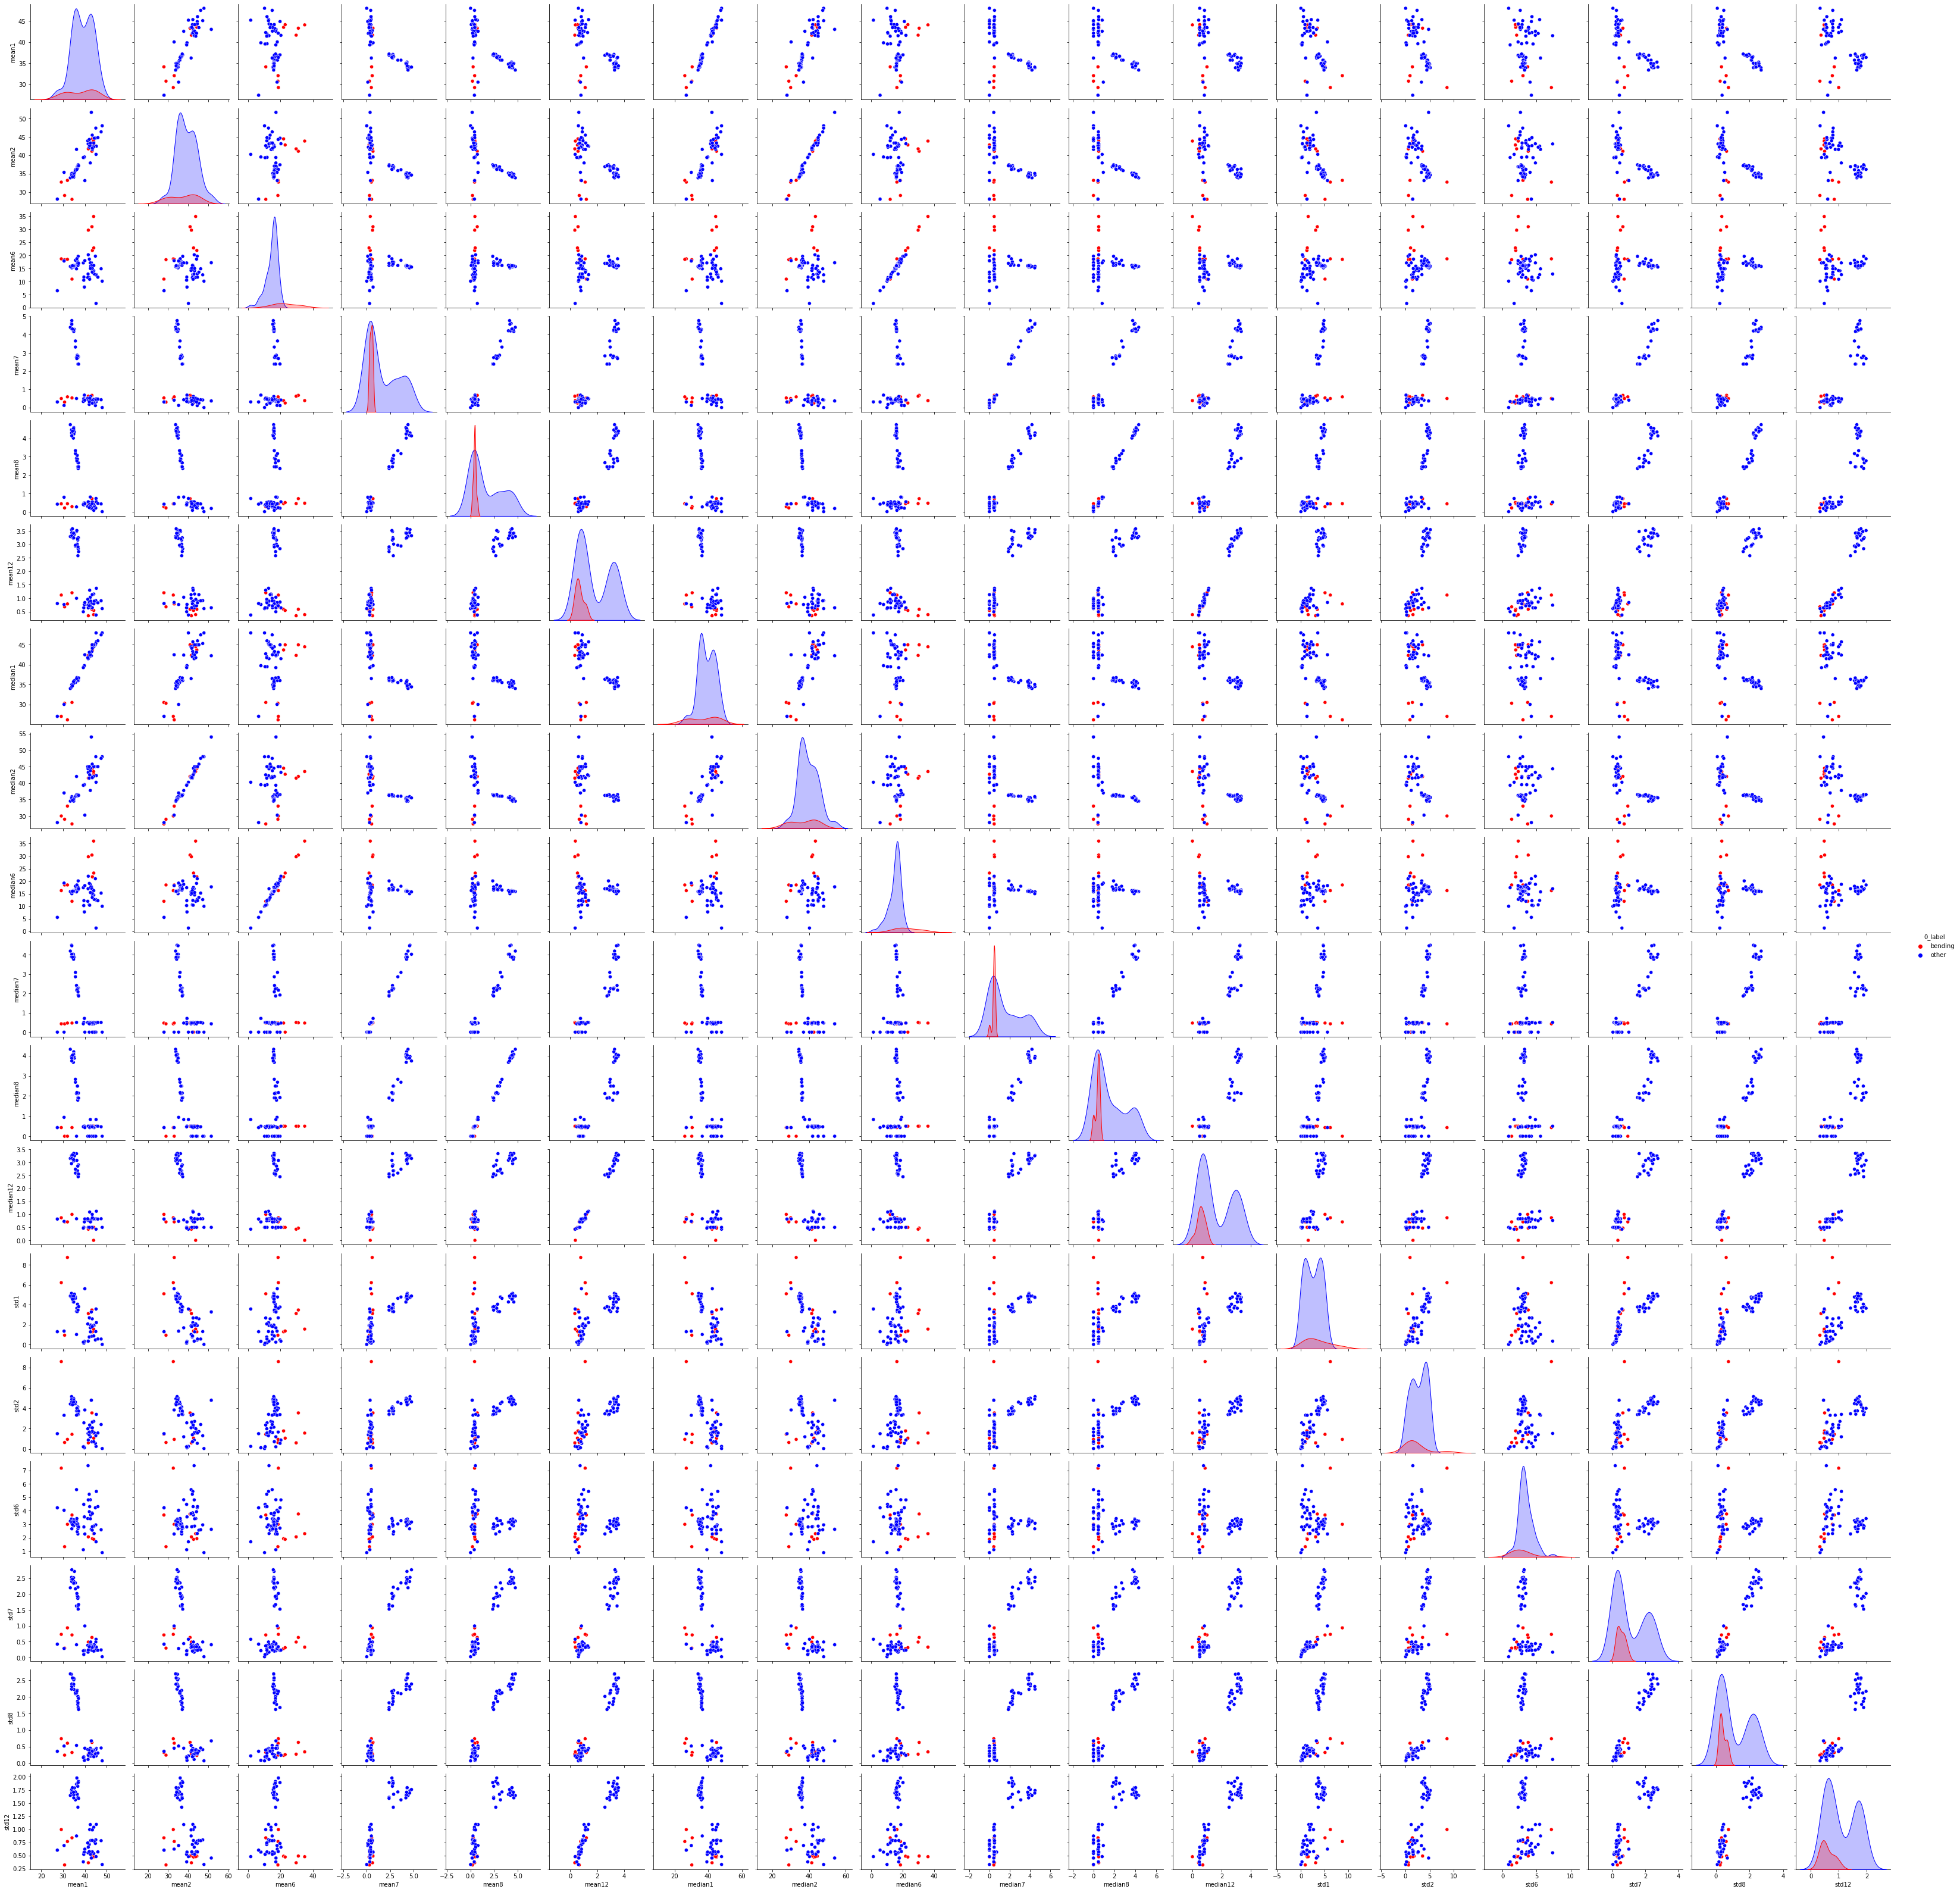

In [12]:
def selection(colList):
    selected = ['0_label']
    for col in ['mean', 'median', 'std']:
        for num in colList:
            selected.append(col+str(num))
    print(selected)
    return selected

sns.pairplot(data=trainDF[selection([1,2,6,7,8,12])], hue='0_label', palette={'bending':'red','other':'blue'})

#### Q. Do you see any considerable difference in the results with those of 2(a)i?
<b> Answer : </b> By dividing each time series in training set into two equal length time series, it became easier to distinguish each activity group (bending or otherwise) compared to the 2(a)i.

### iii. 
- 1. Break each time series in your training set into l ∈ {1,2,...,20} time series of approximately equal length 
- 2. Use logistic regression to solve the binary classification problem, using time-domain features.
- 3. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l 
- 4. Refit a logistic regression model using your pruned set of features. Alternatively, you can use backward selection using sklearn.feature selection. 
- 5. Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination.

In [13]:
LogisticDF = pd.DataFrame(columns=['l', 'best_Features_Length', 'best_Features', 'Cross-validation_accuracy', 'ROC_score'])

for l in range(1,21):
    accuracyScore = []
    selectedFeatures = []
    scoreROCAUC = []
    trainDF, testDF = break_time_series_dataset(l, True)
    trainDF_X, trainDF_Y = trainDF.iloc[:,1:], trainDF['0_label'].replace('bending',0).replace('other',1)
    testDF_X, testDF_Y = testDF.iloc[:,1:], testDF['0_label'].replace('bending',0).replace('other',1)
    
    print(l, '----------------------------')
    Nfold = 5
    cv = StratifiedKFold(n_splits=Nfold, shuffle=True)
    for train_idx, valid_idx in cv.split(trainDF_X, trainDF_Y):
        X_train, X_valid = trainDF_X.loc[train_idx], trainDF_X.loc[valid_idx]
        y_train, y_valid = trainDF_Y.loc[train_idx], trainDF_Y.loc[valid_idx]
    
        # Fit the model
        model = LogisticRegression(solver='liblinear')
        rfe = RFECV(estimator=model, cv=StratifiedKFold(Nfold)).fit(X_train, y_train)
    
        # Find the best features
        bestFeatures = []
        for i in range(len(rfe.support_)):
            if rfe.support_[i]==True:
                bestFeatures.append(i)
    
        # Retrain the model with best features
        newX_train = X_train.iloc[:,bestFeatures]
        newX_train_valid = X_valid.iloc[:,bestFeatures]
        model2 = LogisticRegression(solver='liblinear').fit(newX_train, y_train)
        predicted_y = model2.predict(newX_train_valid)
        
        # Calculate accuracy using validation datasets
        accuracy = accuracy_score(y_valid, predicted_y)
        
        # Calculate AUC score
        roc_auc = roc_auc_score(y_valid, model2.predict_proba(newX_train_valid)[:, 1])
        
        # Store each score into temperary list
        accuracyScore.append(accuracy)
        selectedFeatures.append(bestFeatures)
        scoreROCAUC.append(roc_auc)
    
                       
    # Choose the model based on performance (accuracy) on the validation set
    bestIdx = np.argmax(accuracyScore)
    bestFeaturesLen = len(selectedFeatures[bestIdx])
    bestFeaturesL = selectedFeatures[bestIdx]
    bestAccuracy = np.mean(accuracyScore)
    bestROCAUC = np.mean(scoreROCAUC)
    
    row = []
    row.append(l)
    row.append(bestFeaturesLen)
    row.append(bestFeaturesL)
    row.append(bestAccuracy)
    row.append(bestROCAUC)
    
    LogisticDF.loc[len(LogisticDF)] = row 

1 ----------------------------
2 ----------------------------
3 ----------------------------
4 ----------------------------
5 ----------------------------
6 ----------------------------
7 ----------------------------
8 ----------------------------
9 ----------------------------
10 ----------------------------
11 ----------------------------
12 ----------------------------
13 ----------------------------
14 ----------------------------
15 ----------------------------
16 ----------------------------
17 ----------------------------
18 ----------------------------
19 ----------------------------
20 ----------------------------


In [14]:
LogisticDF

,l,best_Features_Length,best_Features,Cross-validation_accuracy,ROC_score
0,1,4,"[2, 6, 14, 15]",1.000000,1.000000
1,2,5,"[28, 34, 35, 48, 64]",0.941758,0.933333
2,3,5,"[19, 24, 42, 45, 96]",1.000000,1.000000
3,4,8,"[4, 26, 32, 56, 70, 71, 80, 131]",0.942857,0.991667
4,5,5,"[32, 40, 87, 100, 161]",0.942857,0.975000
5,6,11,"[17, 40, 48, 72, 84, 85, 91, 105, 147, 193, 195]",0.942857,0.983333
6,7,3,"[56, 87, 98]",0.941758,0.991667
7,8,4,"[52, 65, 143, 262]",0.927473,0.975000
8,9,3,"[112, 126, 290]",0.941758,0.991667
9,10,2,"[21, 124]",0.927473,0.850000


#### Q. Explain what the right way and the wrong way are to perform cross-validation in this problem.
<b> Answer : </b> 
- <b>Right way</b> : Choose folds and then select set of predictors is a good way. Also, feature selection step should be inside the cross-validation loop statement. By doing this, it can choose a different set of the top 100 predictors.
- <b> Wrong way </b> : First, select the set of predictors and then choose folds is a wrong way

#### Q. Research what stratified cross-validation means.
<b> Answer : </b> Stratified sampling is a sampling technique where the samples are selected in the same proportion (by dividing the population into groups called ‘strata’ based on a characteristic) as they appear in the population.

#### Q. The best value of the pair (l, p), where p is the number of features.
<b> Answer : </b> The best value for a pair (l,p) I choose is (1, 4). This is because the mean of cross-validation accuracy and AUC score are the hightest when l=1.

### iv. 
- Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

Accuracy ------------------------------------------------------

0.8985507246376812

Confusion matrix ------------------------------------------------------

[[ 5  4]
 [ 3 57]]

AUC score ------------------------------------------------------

0.9648148148148148

ROC curve ------------------------------------------------------



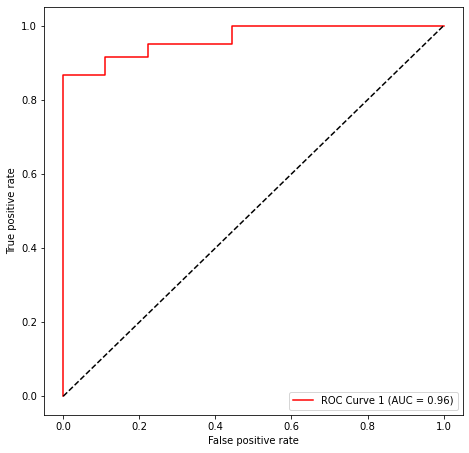

------------------------------------------------------

Report the parameters of your logistic regression βi’s as well as the p-values associated with them. 

------------------------------------------------------

Optimization terminated successfully.
         Current function value: 0.150757
         Iterations 11
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.611     
Dependent Variable: 0_label          AIC:              28.8044   
Date:               2022-10-17 23:28 BIC:              37.7409   
No. Observations:   69               Log-Likelihood:   -10.402   
Df Model:           3                LL-Null:          -26.718   
Df Residuals:       65               LLR p-value:      3.8530e-07
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     11.0000                                      
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|

In [15]:
LogisticBestL = 1
trainDF, testDF = break_time_series_dataset(LogisticBestL, True)
selectedFeatures = LogisticDF.loc[LogisticBestL-1,'best_Features']
trainDF_X, trainDF_Y = trainDF.iloc[:,selectedFeatures], trainDF.iloc[:,0].replace('bending',0).replace('other',1)

# Best (L, P) pair
Logisticmodel = LogisticRegression(solver='liblinear')
Logisticmodel = Logisticmodel.fit(trainDF_X, trainDF_Y)
predicted_y = Logisticmodel.predict(trainDF_X)

# Accuracy
print('Accuracy ------------------------------------------------------\n')
Logistic_acc = accuracy_score(trainDF_Y, predicted_y)
print(Logistic_acc)
print()

# Confusion Matrix
print('Confusion matrix ------------------------------------------------------\n')
cm = confusion_matrix(trainDF_Y, predicted_y)
print(cm)
print()

# AUC score & ROC curve
fpr, tpr, thresholds = roc_curve(trainDF_Y, Logisticmodel.predict_proba(trainDF_X)[:, 1])
Logistic_roc_auc = auc(fpr, tpr)
print('AUC score ------------------------------------------------------\n')
print(Logistic_roc_auc)
print()

print('ROC curve ------------------------------------------------------\n')
fig, ax = plt.subplots(figsize=(7.5, 7.5))
plt.plot(fpr, tpr, color='red', label='ROC Curve 1 (AUC = %0.2f)' % (Logistic_roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()


print('------------------------------------------------------\n')
print('Report the parameters of your logistic regression βi’s as well as the p-values associated with them. \n')
print('------------------------------------------------------\n')
logitic_model = sm.Logit(trainDF_Y, trainDF_X)
result = logitic_model.fit()
print(result.summary2())

### Q. Report the parameters
<b> Answer </b> : The table contains coef and P>|t| columns. These represent coefficients and p-values, respectively.
Also, as you can see, the features '1st_quart6 ' and 'max3' are statistically significant when checking the p-value.

### v. 
- Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

------------------------------------------------------

Test Set 

------------------------------------------------------

Accuracy ------------------------------------------------------

0.8421052631578947

Confusion matrix ------------------------------------------------------

[[ 2  2]
 [ 1 14]]

AUC score ------------------------------------------------------

0.8333333333333334

ROC curve ------------------------------------------------------



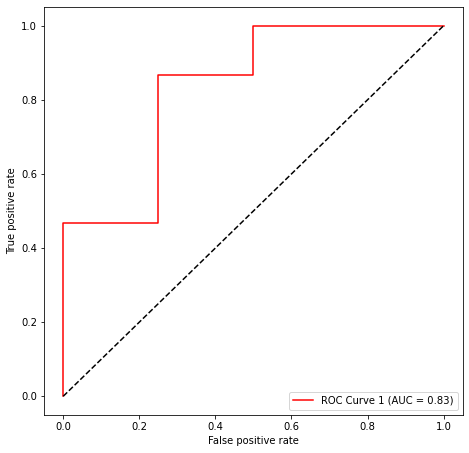

------------------------------------------------------

Compare bewteen train and test accuracy 

------------------------------------------------------



,Train(Cross-validation)_accuracy,Test_accuracy
Comparison,0.898551,0.842105


In [16]:
print('------------------------------------------------------\n')
print('Test Set \n')
print('------------------------------------------------------\n')
testDF_X, testDF_Y = testDF.iloc[:,selectedFeatures], testDF.iloc[:,0].replace('bending',0).replace('other',1)
predicted_test = Logisticmodel.predict(testDF_X)

# Accuracy
print('Accuracy ------------------------------------------------------\n')
Logistic_test_acc = accuracy_score(testDF_Y, predicted_test)
print(Logistic_test_acc)
print()

# Confusion Matrix
print('Confusion matrix ------------------------------------------------------\n')
print(confusion_matrix(testDF_Y, predicted_test))
print()

# AUC score & ROC curve
fpr, tpr, thresholds = roc_curve(testDF_Y, Logisticmodel.predict_proba(testDF_X)[:, 1])
Logistic_test_roc_auc = auc(fpr, tpr)
print('AUC score ------------------------------------------------------\n')
print(Logistic_test_roc_auc)
print()

print('ROC curve ------------------------------------------------------\n')
fig, ax = plt.subplots(figsize=(7.5, 7.5))
plt.plot(fpr, tpr, color='red', label='ROC Curve 1 (AUC = %0.2f)' % (Logistic_test_roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()

print('------------------------------------------------------\n')
print('Compare bewteen train and test accuracy \n')
print('------------------------------------------------------\n')
compareDic = [Logistic_acc, Logistic_test_acc]
table = pd.DataFrame(columns=['Train(Cross-validation)_accuracy','Test_accuracy'], index=['Comparison'])
table.loc['Comparison'] = compareDic
table

#### Q. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.
<b> Answer</b> : As you can see the table, the average of cross-validation accuracy of the training dataset is higher than that of the test dataset.

#### Q. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?
<b> Answer </b> : No, the classes are not well separated. In the case of the bending class, most of the answers were incorrect in the training set. Although k-fold validation is used, it seems that minority class (bending) is not properly trained due to a small amount of data.

#### Q. From the confusion matrices you obtained, do you see imbalanced classes?
<b> Answer </b> : Yes, both the training and test datasets are imbalanced. The number of bending in both the training and test datasets are relatively fewer than the non-bending class.

#### If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

In [17]:
trainDF, testDF = break_time_series_dataset(LogisticBestL, True)
selectedFeatures = LogisticDF.loc[LogisticBestL-1,'best_Features']
trainDF_X, trainDF_Y = trainDF.iloc[:,selectedFeatures], trainDF['0_label']
testDF_X, testDF_Y = testDF.iloc[:,selectedFeatures], testDF['0_label']

before_cntDic = collections.Counter(list(trainDF_Y))
print('------------------------------------------------------------------')
print('Before SMOTE sampling, the number of bending:', before_cntDic['bending'])
print('Before SMOTE sampling, the number of others:', before_cntDic['other'])
print('------------------------------------------------------------------')

smote = SMOTE(sampling_strategy='all')
SMOTE_trainDF_X, SMOTE_trainDF_Y = smote.fit_resample(trainDF_X, trainDF_Y)
after_cntDic = collections.Counter(list(SMOTE_trainDF_Y))
print('------------------------------------------------------------------')
print('After SMOTE sampling, the number of bending:', after_cntDic['bending'])
print('After SMOTE sampling, the number of other:', after_cntDic['other'])
print('------------------------------------------------------------------')

------------------------------------------------------------------
Before SMOTE sampling, the number of bending: 9
Before SMOTE sampling, the number of others: 60
------------------------------------------------------------------
------------------------------------------------------------------
After SMOTE sampling, the number of bending: 60
After SMOTE sampling, the number of other: 60
------------------------------------------------------------------


#### Report the confusion matrix, ROC, and AUC of the model with train dataset

------------------------------------------------------

Train Set 

------------------------------------------------------

Accuracy ------------------------------------------------------

0.9583333333333334
Confusion_matrix ------------------------------------------------------

[[60  0]
 [ 5 55]]
AUC score ------------------------------------------------------

1.0

ROC curve ------------------------------------------------------



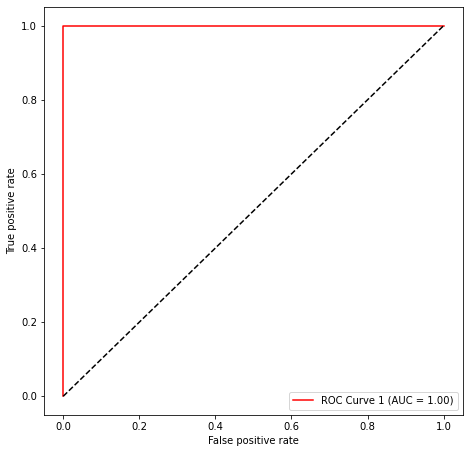

In [18]:
print('------------------------------------------------------\n')
print('Train Set \n')
print('------------------------------------------------------\n')

SMOTEmodel = LogisticRegression(solver='liblinear').fit(SMOTE_trainDF_X, SMOTE_trainDF_Y)
predicted_y = SMOTEmodel.predict(SMOTE_trainDF_X)

# Accuracy
print('Accuracy ------------------------------------------------------\n')
accuracy = accuracy_score(SMOTE_trainDF_Y, predicted_y)
print(accuracy)

# Confusion matrix
print('Confusion_matrix ------------------------------------------------------\n')
print(confusion_matrix(SMOTE_trainDF_Y, predicted_y))

# AUC score & ROC curve
fpr, tpr, thresholds = roc_curve(SMOTE_trainDF_Y, SMOTEmodel.predict_proba(SMOTE_trainDF_X)[:, 1], pos_label='other')
roc_auc = auc(fpr, tpr)
print('AUC score ------------------------------------------------------\n')
print(roc_auc)
print()

print('ROC curve ------------------------------------------------------\n')
fig, ax = plt.subplots(figsize=(7.5, 7.5))
plt.plot(fpr, tpr, color='red', label='ROC Curve 1 (AUC = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()

#### Report the confusion matrix, ROC, and AUC of the model with test dataset

------------------------------------------------------

Test Set 

------------------------------------------------------

Accuracy ------------------------------------------------------

0.7894736842105263
Confusion matrix ------------------------------------------------------

[[ 2  2]
 [ 2 13]]
AUC score ------------------------------------------------------

0.8833333333333333

ROC curve ------------------------------------------------------



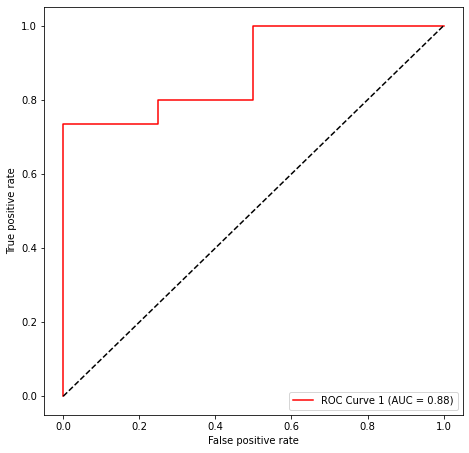

In [19]:
print('------------------------------------------------------\n')
print('Test Set \n')
print('------------------------------------------------------\n')

predicted_y = SMOTEmodel.predict(testDF_X)
accuracy = accuracy_score(testDF_Y, predicted_y)
print('Accuracy ------------------------------------------------------\n')
print(accuracy)
print('Confusion matrix ------------------------------------------------------\n')
print(confusion_matrix(testDF_Y, predicted_y))

# AUC score & ROC curve
fpr, tpr, thresholds = roc_curve(testDF_Y, SMOTEmodel.predict_proba(testDF_X)[:, 1], pos_label='other')
roc_auc = auc(fpr, tpr)
print('AUC score ------------------------------------------------------\n')
print(roc_auc)
print()

print('ROC curve ------------------------------------------------------\n')
fig, ax = plt.subplots(figsize=(7.5, 7.5))
plt.plot(fpr, tpr, color='red', label='ROC Curve 1 (AUC = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()

## (b) Binary Classification Using L1-penalized logistic regression

### i. 
- Repeat 2(a)iii using L1-penalized logistic regression i.e. instead of using p-values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.

In [20]:
def normalize(df):
    norm = preprocessing.MinMaxScaler()
    normed_X = norm.fit_transform(df.values)
    trainDF_X = pd.DataFrame(normed_X, columns=df.columns)
    
    return trainDF_X

In [21]:
L1penalizedDF = pd.DataFrame(columns=['l', 'best_Lambda', 'Accuracy', 'AUC_score'])

for l in range(1,21):
    accuracyScore = []
    lambdaValue = []
    scoreROCAUC = []
    trainDF, testDF = break_time_series_dataset(l, True)
    trainDF_X, trainDF_Y = trainDF.iloc[:,1:], trainDF['0_label'].replace('bending',0).replace('other',1)
    testDF_X, testDF_Y = testDF.iloc[:,1:], testDF['0_label'].replace('bending',0).replace('other',1)
    
    # normalize data
    trainDF_X = normalize(trainDF_X)
    testDF_X = normalize(testDF_X)
    
    print(l, '----------------------------')
    Nfold = 5
    cv = StratifiedKFold(n_splits=Nfold, shuffle=True)
    for train_idx, valid_idx in cv.split(trainDF_X, trainDF_Y):
        X_train, X_valid = trainDF_X.loc[train_idx], trainDF_X.loc[valid_idx]
        y_train, y_valid = trainDF_Y.loc[train_idx], trainDF_Y.loc[valid_idx]
    
        # Fit the model
        L1model = LogisticRegressionCV(cv=5, solver='liblinear', penalty='l1').fit(X_train, y_train)
        penalty = L1model.C_[0]
        lambdaVal = float(1/penalty)
        predicted_y = L1model.predict(X_valid)
        
        # Find accuracy using validation datasets
        accuracy = accuracy_score(y_valid, predicted_y)
        roc_auc = roc_auc_score(y_valid, L1model.predict_proba(X_valid)[:, 1])
        
        accuracyScore.append(accuracy)
        lambdaValue.append(lambdaVal)
        scoreROCAUC.append(roc_auc)
    
                       
    # I will choose the model based on performance on the validation set, which means the highest cross-validation accuracy.
    bestIdx = np.argmax(accuracyScore)
    bestLambda = lambdaValue[bestIdx]
    bestAccuracy = np.mean(accuracyScore)
    bestROCAUC = np.mean(scoreROCAUC)
    
    row = []
    row.append(l)
    row.append(bestLambda)
    row.append(bestAccuracy)
    row.append(bestROCAUC)
    
    L1penalizedDF.loc[len(L1penalizedDF)] = row 

1 ----------------------------
2 ----------------------------
3 ----------------------------
4 ----------------------------
5 ----------------------------
6 ----------------------------
7 ----------------------------
8 ----------------------------
9 ----------------------------
10 ----------------------------
11 ----------------------------
12 ----------------------------
13 ----------------------------
14 ----------------------------
15 ----------------------------
16 ----------------------------
17 ----------------------------
18 ----------------------------
19 ----------------------------
20 ----------------------------


In [22]:
L1penalizedDF

,l,best_Lambda,Accuracy,AUC_score
0,1.0,0.000774,0.940659,0.983333
1,2.0,0.046416,0.913187,0.975000
2,3.0,0.046416,0.957143,0.991667
3,4.0,0.046416,0.912088,0.966667
4,5.0,0.046416,0.914286,0.941667
5,6.0,0.046416,0.913187,1.000000
6,7.0,0.000774,0.883516,0.958333
7,8.0,0.359381,0.898901,0.966667
8,9.0,0.046416,0.898901,0.941667
9,10.0,0.000774,0.884615,0.908333


#### Q. Best L?
<b> Answer </b> : I will choose l = 3 because it has the highest cross-validation accuracy.

------------------------------------------------------

Training Set 

------------------------------------------------------

Confusion matrix ------------------------------------------------------

[[ 9  0]
 [ 0 60]]

Accuracy ------------------------------------------------------

1.0

AUC score ------------------------------------------------------

1.0

ROC curve ------------------------------------------------------



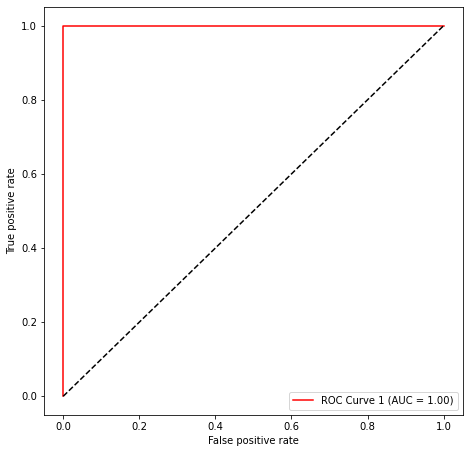

In [23]:
bestL = 3

bestLambda = L1penalizedDF.loc[bestL-1,'best_Lambda']
bestC = float(1/bestLambda)

trainDF, testDF = break_time_series_dataset(bestL, True)
trainDF_X, trainDF_Y = trainDF.iloc[:,1:], trainDF['0_label'].replace('bending',0).replace('other',1)
testDF_X, testDF_Y = testDF.iloc[:,1:], testDF['0_label'].replace('bending',0).replace('other',1)

# normalize data
trainDF_X = normalize(trainDF_X)
testDF_X = normalize(testDF_X)

L1model = LogisticRegression(solver='liblinear', penalty='l1', C=bestC).fit(trainDF_X, trainDF_Y)
predicted_y = L1model.predict(trainDF_X)

print('------------------------------------------------------\n')
print('Training Set \n')
print('------------------------------------------------------\n')

# Confusion Matrix
print('Confusion matrix ------------------------------------------------------\n')
cm = confusion_matrix(trainDF_Y, predicted_y)
print(cm)
print()

# Accuracy
print('Accuracy ------------------------------------------------------\n')
L1_acc = accuracy_score(trainDF_Y, predicted_y)
print(L1_acc)
print()

# AUC score & ROC curve
fpr, tpr, thresholds = roc_curve(trainDF_Y, L1model.predict_proba(trainDF_X)[:, 1])
L1_roc_auc = auc(fpr, tpr)
print('AUC score ------------------------------------------------------\n')
print(L1_roc_auc)
print()

print('ROC curve ------------------------------------------------------\n')
fig, ax = plt.subplots(figsize=(7.5, 7.5))
plt.plot(fpr, tpr, color='red', label='ROC Curve 1 (AUC = %0.2f)' % (L1_roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()

------------------------------------------------------

Test Set 

------------------------------------------------------

Confusion matrix ------------------------------------------------------

[[ 3  1]
 [ 1 14]]

Accuracy ------------------------------------------------------

0.8947368421052632

AUC score ------------------------------------------------------

0.9833333333333334

ROC curve ------------------------------------------------------



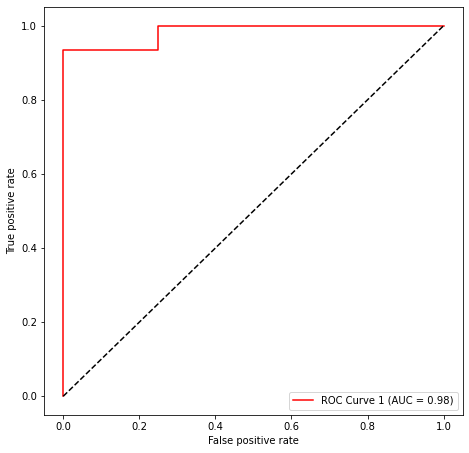

In [24]:
print('------------------------------------------------------\n')
print('Test Set \n')
print('------------------------------------------------------\n')
test_predicted_y = L1model.predict(testDF_X)

# Confusion Matrix
print('Confusion matrix ------------------------------------------------------\n')
cm = confusion_matrix(testDF_Y, test_predicted_y)
print(cm)
print()

# Accuracy
print('Accuracy ------------------------------------------------------\n')
L1_test_acc = accuracy_score(testDF_Y, test_predicted_y)
print(L1_test_acc)
print()

# AUC score & ROC curve
fpr, tpr, thresholds = roc_curve(testDF_Y, L1model.predict_proba(testDF_X)[:, 1])
L1_test_roc_auc = auc(fpr, tpr)
print('AUC score ------------------------------------------------------\n')
print(L1_test_roc_auc)
print()

print('ROC curve ------------------------------------------------------\n')
fig, ax = plt.subplots(figsize=(7.5, 7.5))
plt.plot(fpr, tpr, color='red', label='ROC Curve 1 (AUC = %0.2f)' % (L1_test_roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()

In [25]:
table1 = pd.DataFrame(columns=['Logistic', 'L1_penalized'], 
                      index=['Accuracy for training data', 'Accuracy for testing data',
                            'AUC score for training data', 'AUC score for testing data'])

row = []
row.append(Logistic_acc)
row.append(L1_acc)
table1.loc['Accuracy for training data'] = row 

row = []
row.append(Logistic_test_acc)
row.append(L1_test_acc)
table1.loc['Accuracy for testing data'] = row 

row = []
row.append(Logistic_roc_auc)
row.append(L1_roc_auc)
table1.loc['AUC score for training data'] = row 

row = []
row.append(Logistic_test_roc_auc)
row.append(L1_test_roc_auc)
table1.loc['AUC score for testing data'] = row 

table1

,Logistic,L1_penalized
Accuracy for training data,0.898551,1.0
Accuracy for testing data,0.842105,0.894737
AUC score for training data,0.964815,1.0
AUC score for testing data,0.833333,0.983333


#### Q. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.
<b> Answer </b> : As you can see the table above, the training and testing accuracy for L1-penalized Logistic Regression model has much better performance than Logistic Regression with variable selection. Also, L1-penalized model is also easy to implement, by just adding a parameter.

### (c) Multi-class Classification (The Realistic Case)

### i. 
- Find the best l in the same way as you found it in 2(b)i to build an L1-penalized multinomial regression model to classify all activities in your training set. 

In [26]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
MultiL1penalizedDF = pd.DataFrame(columns=['l', 'best_Lambda', 'Accuracy', 'Penalty'])
className = {'bending1':0, 'bending2':1, 'cycling':2, 'lying':3, 'sitting':4, 'standing':5, 'walking':6}

for l in range(1,21):
    accuracyScore = []
    lambdaValue = []
    penaltyList = []
    trainDF, testDF = break_time_series_dataset(l, False)
    trainDF_X, trainDF_Y = trainDF.iloc[:,1:], trainDF[['0_label']].replace({"0_label": className})
    testDF_X, testDF_Y = testDF.iloc[:,1:], testDF[['0_label']].replace({"0_label": className})

    # normalize data
    trainDF_X = normalize(trainDF_X)
    testDF_X = normalize(testDF_X)
    
    print(l, '----------------------------')
    Nfold = 5
    cv = StratifiedKFold(n_splits=Nfold, shuffle=True)
    for train_idx, valid_idx in cv.split(trainDF_X, trainDF_Y):
        X_train, X_valid = trainDF_X.loc[train_idx], trainDF_X.loc[valid_idx]
        y_train, y_valid = trainDF_Y.loc[train_idx], trainDF_Y.loc[valid_idx]
    
        # Fit the model
        MultiL1model = LogisticRegressionCV(cv=5, solver='liblinear', penalty='l1', multi_class='auto').fit(X_train, y_train)
        penalty = MultiL1model.C_[0]
        lambdaVal = float(1/penalty)
        predicted_y = MultiL1model.predict(X_valid)
        
        # Find accuracy using validation datasets
        accuracy = accuracy_score(y_valid, predicted_y)
        penaltyList.append(penalty)
        accuracyScore.append(accuracy)
        lambdaValue.append(lambdaVal)
    
                       
    # I will choose the model based on performance on the validation set, which means the highest cross-validation accuracy.
    bestIdx = np.argmax(accuracyScore)
    bestLambda = lambdaValue[bestIdx]
    bestAccuracy = np.mean(accuracyScore)
    bestPenalty = penaltyList[bestIdx]
    
    row = []
    row.append(l)
    row.append(bestLambda)
    row.append(bestAccuracy)
    row.append(bestPenalty)
    
    MultiL1penalizedDF.loc[len(MultiL1penalizedDF)] = row 

1 ----------------------------
2 ----------------------------
3 ----------------------------
4 ----------------------------
5 ----------------------------
6 ----------------------------
7 ----------------------------
8 ----------------------------
9 ----------------------------
10 ----------------------------
11 ----------------------------
12 ----------------------------
13 ----------------------------
14 ----------------------------
15 ----------------------------
16 ----------------------------
17 ----------------------------
18 ----------------------------
19 ----------------------------
20 ----------------------------


In [28]:
MultiL1penalizedDF

,l,best_Lambda,Accuracy,Penalty
0,1.0,0.359381,0.739560,2.782559
1,2.0,0.359381,0.783516,2.782559
2,3.0,0.359381,0.696703,2.782559
3,4.0,0.005995,0.740659,166.810054
4,5.0,0.359381,0.698901,2.782559
5,6.0,0.359381,0.682418,2.782559
6,7.0,0.046416,0.709890,21.544347
7,8.0,0.359381,0.652747,2.782559
8,9.0,0.359381,0.726374,2.782559
9,10.0,0.359381,0.712088,2.782559


#### Q. Best L?
<b> Answer </b> : I will choose l = 2 because it has the highest cross-validation accuracy.

In [29]:
bestL = 2
bestLambda = L1penalizedDF.loc[bestL-1,'best_Lambda']
bestC = float(1/bestLambda)
trainDF, testDF = break_time_series_dataset(bestL, False)
trainDF_X, trainDF_Y = trainDF.iloc[:,1:], trainDF[['0_label']].replace({"0_label": className})
testDF_X, testDF_Y = testDF.iloc[:,1:], testDF[['0_label']].replace({"0_label": className})    

# normalize data
trainDF_X = normalize(trainDF_X)
MultiL1model = LogisticRegression(solver='liblinear', penalty='l1', C=bestC, multi_class='auto')
MultiL1model = MultiL1model.fit(trainDF_X, trainDF_Y)
predicted_y = MultiL1model.predict(trainDF_X)

print('------------------------------------------------------\n')
print('Training Set \n')
print('------------------------------------------------------\n')


# Test Accuracy
print('Accuracy ------------------------------------------------------\n')
Multclass_acc = accuracy_score(trainDF_Y, predicted_y)
print(Multclass_acc)
print()


# Confusion Matrix
print('Confusion matrix ------------------------------------------------------\n')
cm = confusion_matrix(trainDF_Y, predicted_y)
print(cm)
print()

print('------------------------------------------------------\n')
print('Test Set \n')
print('------------------------------------------------------\n')

# normalize data
testDF_X = normalize(testDF_X)
test_predicted_y = MultiL1model.predict(testDF_X)

# Test Accuracy
print('Accuracy ------------------------------------------------------\n')
Multclass_test_acc = accuracy_score(testDF_Y, test_predicted_y)
print(Multclass_test_acc)
print()

# Confusion Matrix
print('Confusion matrix ------------------------------------------------------\n')
cm = confusion_matrix(testDF_Y, test_predicted_y)
print(cm)
print()

# Test Error
print('Test Error ------------------------------------------------------\n')
Multclass_test_error = 1- accuracy_score(testDF_Y, test_predicted_y)
print("Test Error : %f"%Multclass_test_error)
print()

------------------------------------------------------

Training Set 

------------------------------------------------------

Accuracy ------------------------------------------------------

1.0

Confusion matrix ------------------------------------------------------

[[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]]

------------------------------------------------------

Test Set 

------------------------------------------------------

Accuracy ------------------------------------------------------

0.8421052631578947

Confusion matrix ------------------------------------------------------

[[2 0 0 0 0 0 0]
 [0 1 0 0 1 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 0 3]]

Test Error ------------------------------------------------------

Test Error : 0.157895



#### Q. Test Error?
<b> Answer </b> : 0.157895

#### Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

In [30]:
def multiClassROC(classes, model, trainDF_Y, testDF_X, testDF_Y):
    lableBinarizer = preprocessing.LabelBinarizer()
    lableBinarizer.fit(trainDF_Y)
    trainDF_Y = lableBinarizer.transform(trainDF_Y)
    testDF_Y = lableBinarizer.transform(testDF_Y)

    predicted_probaY = model.predict_proba(testDF_X)

    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(0, len(classes)):
        fpr[i], tpr[i], _ = roc_curve(testDF_Y[:, i], predicted_probaY[:, i])
        roc_auc[i] = round(auc(fpr[i], tpr[i]), 2)

    for i in range(0, len(classes)):
        className = classes[i]
        label = 'ROC of ' + className + ' AUC: ' + str(roc_auc[i])
        plt.plot(fpr[i], tpr[i], label=label)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend()
    return plt, roc_auc

In [31]:
# Confusion Matrix
print('Confusion matrix For test datasets ------------------------------------------------------\n')
cm = confusion_matrix(testDF_Y, test_predicted_y)
print(cm)
print()

Confusion matrix For test datasets ------------------------------------------------------

[[2 0 0 0 0 0 0]
 [0 1 0 0 1 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 0 3]]



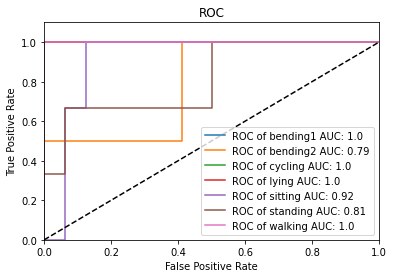

In [32]:
classes = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
multoclass_roc, multiclass_auc = multiClassROC(classes, MultiL1model, trainDF_Y, testDF_X, testDF_Y)
multoclass_roc.show()

### ii. Repeat 2(c)i using a Na ̈ıve Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results.

#### Gaussian Naive Bayes

In [33]:
GaussianNBDF = pd.DataFrame(columns=['l','Accuracy'])

for l in range(1,21):
    accuracyScore = []
    scoreROCAUC = []
    trainDF, testDF = break_time_series_dataset(l, False)
    trainDF_X, trainDF_Y = trainDF.iloc[:,1:], trainDF[['0_label']].replace({"0_label": className})
    testDF_X, testDF_Y = testDF.iloc[:,1:], testDF[['0_label']].replace({"0_label": className})    

    print(l, '----------------------------')
    Nfold = 5
    cv = StratifiedKFold(n_splits=Nfold, shuffle=True)
    for train_idx, valid_idx in cv.split(trainDF_X, trainDF_Y):
        X_train, X_valid = trainDF_X.loc[train_idx], trainDF_X.loc[valid_idx]
        y_train, y_valid = trainDF_Y.loc[train_idx], trainDF_Y.loc[valid_idx]
    

        # Fit gaussian naive bayes classifier
        gaussianModel = GaussianNB()
        gaussianModel = gaussianModel.fit(X_train, y_train)
        predicted_y = gaussianModel.predict(X_valid)
        
        # Find accuracy using validation datasets
        accuracy = accuracy_score(y_valid, predicted_y)
        accuracyScore.append(accuracy)
    
                       
    # I will choose the model based on performance on the validation set, which means the highest cross-validation accuracy.
    bestIdx = np.argmax(accuracyScore)
    bestAccuracy = np.mean(accuracyScore)
    
    row = []
    row.append(l)
    row.append(bestAccuracy)
    
    GaussianNBDF.loc[len(GaussianNBDF)] = row 

1 ----------------------------
2 ----------------------------
3 ----------------------------
4 ----------------------------
5 ----------------------------
6 ----------------------------
7 ----------------------------
8 ----------------------------
9 ----------------------------
10 ----------------------------
11 ----------------------------
12 ----------------------------
13 ----------------------------
14 ----------------------------
15 ----------------------------
16 ----------------------------
17 ----------------------------
18 ----------------------------
19 ----------------------------
20 ----------------------------


In [34]:
GaussianNBDF

,l,Accuracy
0,1.0,0.826374
1,2.0,0.813187
2,3.0,0.710989
3,4.0,0.681319
4,5.0,0.724176
5,6.0,0.667033
6,7.0,0.664835
7,8.0,0.681319
8,9.0,0.519780
9,10.0,0.665934


#### Q. Best L?
<b> Answer </b> : I will choose l = 1 because it has the highest cross-validation accuracy.

------------------------------------------------------

Training Set 

------------------------------------------------------

Accuracy ------------------------------------------------------

1.0

Confusion matrix ------------------------------------------------------

[[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]]

------------------------------------------------------

Test Set 

------------------------------------------------------

Accuracy ------------------------------------------------------

0.8947368421052632

Confusion matrix ------------------------------------------------------

[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 1 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]

ROC curve ------------------------------------------------------



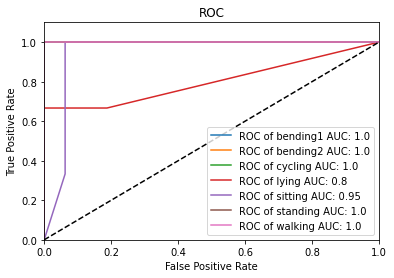

In [37]:
bestL = 1
trainDF, testDF = break_time_series_dataset(bestL, False)
trainDF_X, trainDF_Y = trainDF.iloc[:,1:], trainDF[['0_label']].replace({"0_label": className})
testDF_X, testDF_Y = testDF.iloc[:,1:], testDF[['0_label']].replace({"0_label": className})    


# Fit model
gaussianModel = GaussianNB()
gaussianModel = gaussianModel.fit(trainDF_X, trainDF_Y)
predicted_y = gaussianModel.predict(trainDF_X)
        
print('------------------------------------------------------\n')
print('Training Set \n')
print('------------------------------------------------------\n')

# Accuracy
print('Accuracy ------------------------------------------------------\n')
gaussian_acc = accuracy_score(trainDF_Y, predicted_y)
print(gaussian_acc)
print()

# Confusion Matrix
print('Confusion matrix ------------------------------------------------------\n')
cm = confusion_matrix(trainDF_Y, predicted_y)
print(cm)
print()

print('------------------------------------------------------\n')
print('Test Set \n')
print('------------------------------------------------------\n')

# normalize data
test_predicted_y = gaussianModel.predict(testDF_X)

# Accuracy
print('Accuracy ------------------------------------------------------\n')
gaussian_test_acc = accuracy_score(testDF_Y, test_predicted_y)
print(gaussian_test_acc)
print()


# Confusion Matrix
print('Confusion matrix ------------------------------------------------------\n')
cm = confusion_matrix(testDF_Y, test_predicted_y)
print(cm)
print()


print('ROC curve ------------------------------------------------------\n')
gaussian_roc, gaussian_auc = multiClassROC(classes, gaussianModel, trainDF_Y, testDF_X, testDF_Y)
gaussian_roc.show()

#### Multinomial Naive Bayes

In [38]:
MultinomialDF = pd.DataFrame(columns=['l','Accuracy'])

for l in range(1,21):
    accuracyScore = []
    scoreROCAUC = []
    trainDF, testDF = break_time_series_dataset(l, False)
    trainDF_X, trainDF_Y = trainDF.iloc[:,1:], trainDF[['0_label']].replace({"0_label": className})
    testDF_X, testDF_Y = testDF.iloc[:,1:], testDF[['0_label']].replace({"0_label": className})    
    

    print(l, '----------------------------')
    Nfold = 5
    cv = StratifiedKFold(n_splits=Nfold, shuffle=True)
    for train_idx, valid_idx in cv.split(trainDF_X, trainDF_Y):
        X_train, X_valid = trainDF_X.loc[train_idx], trainDF_X.loc[valid_idx]
        y_train, y_valid = trainDF_Y.loc[train_idx], trainDF_Y.loc[valid_idx]
    
        # Fit gaussian naive bayes classifier
        multinomialModel = MultinomialNB()
        multinomialModel = multinomialModel.fit(X_train, y_train)
        predicted_y = multinomialModel.predict(X_valid)
        
        # Find accuracy using validation datasets
        accuracy = accuracy_score(y_valid, predicted_y)
        accuracyScore.append(accuracy)
    
                       
    # I will choose the model based on performance on the validation set, which means the highest cross-validation accuracy.
    bestIdx = np.argmax(accuracyScore)
    bestAccuracy = np.mean(accuracyScore)
    
    row = []
    row.append(l)
    row.append(bestAccuracy)
    
    MultinomialDF.loc[len(MultinomialDF)] = row 

1 ----------------------------
2 ----------------------------
3 ----------------------------
4 ----------------------------
5 ----------------------------
6 ----------------------------
7 ----------------------------
8 ----------------------------
9 ----------------------------
10 ----------------------------
11 ----------------------------
12 ----------------------------
13 ----------------------------
14 ----------------------------
15 ----------------------------
16 ----------------------------
17 ----------------------------
18 ----------------------------
19 ----------------------------
20 ----------------------------


In [39]:
MultinomialDF

,l,Accuracy
0,1.0,0.871429
1,2.0,0.769231
2,3.0,0.784615
3,4.0,0.797802
4,5.0,0.827473
5,6.0,0.797802
6,7.0,0.826374
7,8.0,0.798901
8,9.0,0.826374
9,10.0,0.813187


#### Q. Best L?
<b> Answer </b> : I will choose l = 1 because it has the highest cross-validation accuracy.

------------------------------------------------------

Training Set 

------------------------------------------------------

Confusion matrix ------------------------------------------------------

[[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  1  0  1 10  0  0]
 [ 0  0  0  0  2 10  0]
 [ 0  0  0  0  0  0 12]]

Accuracy ------------------------------------------------------

0.927536231884058

------------------------------------------------------

Test Set 

------------------------------------------------------

Accuracy ------------------------------------------------------

0.8947368421052632

Confusion matrix ------------------------------------------------------

[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 1 0 2 0]
 [0 0 0 0 0 0 3]]

ROC curve ------------------------------------------------------



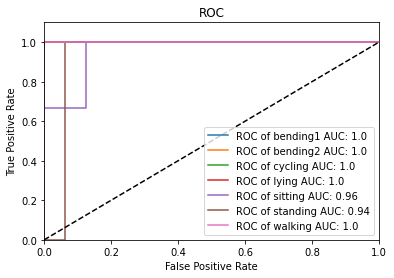

In [40]:
bestL = 1
trainDF, testDF = break_time_series_dataset(bestL, False)
trainDF_X, trainDF_Y = trainDF.iloc[:,1:], trainDF[['0_label']].replace({"0_label": className})
testDF_X, testDF_Y = testDF.iloc[:,1:], testDF[['0_label']].replace({"0_label": className})    

# Fit multinomial Naive bayes classifier
multinomialModel = MultinomialNB()
multinomialModel = multinomialModel.fit(trainDF_X, trainDF_Y)
predicted_y = multinomialModel.predict(trainDF_X)
        
print('------------------------------------------------------\n')
print('Training Set \n')
print('------------------------------------------------------\n')

# Confusion Matrix
print('Confusion matrix ------------------------------------------------------\n')
cm = confusion_matrix(trainDF_Y, predicted_y)
print(cm)
print()

# Accuracy
print('Accuracy ------------------------------------------------------\n')
multinomial_acc = accuracy_score(trainDF_Y, predicted_y)
print(multinomial_acc)
print()


print('------------------------------------------------------\n')
print('Test Set \n')
print('------------------------------------------------------\n')


test_predicted_y = multinomialModel.predict(testDF_X)

# Accuracy
print('Accuracy ------------------------------------------------------\n')
multinomial_test_acc = accuracy_score(testDF_Y, test_predicted_y)
print(multinomial_test_acc)
print()


# Confusion Matrix
print('Confusion matrix ------------------------------------------------------\n')
cm = confusion_matrix(testDF_Y, test_predicted_y)
print(cm)
print()

print('ROC curve ------------------------------------------------------\n')
multinomial_roc, multinomial_auc = multiClassROC(classes, multinomialModel, trainDF_Y, testDF_X, testDF_Y)
multinomial_roc.show()

### iii. 

In [41]:
table1 = pd.DataFrame(columns=['L1-penalized multinomial regression', 'Gaussian Naive Bayes', 'Multinomial Naive Bayes'], 
                      index=['Accuracy for training data', 'Accuracy for testing data'])

row = []
row.append(Multclass_acc)
row.append(gaussian_acc)
row.append(multinomial_acc)
table1.loc['Accuracy for training data'] = row 

row = []
row.append(Multclass_test_acc)
row.append(gaussian_test_acc)
row.append(multinomial_test_acc)
table1.loc['Accuracy for testing data'] = row 

table1

,L1-penalized multinomial regression,Gaussian Naive Bayes,Multinomial Naive Bayes
Accuracy for training data,1.0,1.0,0.927536
Accuracy for testing data,0.842105,0.894737,0.894737


#### Q. Which method is better for multi-class classification in this problem?
<b> Answer </b> : Gaussian Naive Bayes for multi-class classification shows the best performance.

### 3. ISLR 4.8.3

<img src= './../data/ISLR/ISLR-4.8.3.jpg'>

### 4. ISLR 4.8.7

<img src= './../data/ISLR/ISLR-4.8.7.jpg'>

## Reference
- Time-series features : https://stats.stackexchange.com/questions/50807/features-for-time-series-classification 
- bootstrap1 : https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html
- bootstrap2 : https://www.statology.org/bootstrapping-in-python/
- feature selection : https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html
- multinimial : https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html